<a href="https://colab.research.google.com/github/utkarsh-prakash/Google-Colab-Notebooks/blob/main/Automated_Feature_Engineering_Using_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data and Credits


A study by Michael Malin.<br>
https://towardsdatascience.com/automated-feature-engineering-using-neural-networks-5310d6d4280a

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow import feature_column
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt

In [2]:
X_train = pd.read_csv('https://raw.githubusercontent.com/utkarsh-prakash/Data/main/Covid%20Severity.csv')
y_train = X_train.pop('Severity_Severe').to_frame()
X_train.rename(columns={'Age_60+':'Age_60_'}, inplace=True)
X_train

,Fever,Tiredness,Dry-Cough,Difficulty-in-Breathing,Sore-Throat,None_Sympton,Pains,Nasal-Congestion,Runny-Nose,Diarrhea,None_Experiencing,Age_0-9,Age_10-19,Age_20-24,Age_25-59,Age_60_,Gender_Female,Gender_Male,Gender_Transgender,Severity_Mild,Severity_Moderate,Severity_None,Contact_Dont-Know,Contact_No,Contact_Yes,Country
0,1,1,1,1,1,0,1,1,1,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,China
1,1,1,1,1,1,0,1,1,1,1,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,China
2,1,1,1,1,1,0,1,1,1,1,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,China
3,1,1,1,1,1,0,1,1,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,China
4,1,1,1,1,1,0,1,1,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,China
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316795,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,Other
316796,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,Other
316797,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,Other
316798,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,1,0,Other


In [3]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,test_size=0.2,random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val,test_size=0.5,random_state=42)

In [4]:
X_train.columns

Index(['Fever', 'Tiredness', 'Dry-Cough', 'Difficulty-in-Breathing',
       'Sore-Throat', 'None_Sympton', 'Pains', 'Nasal-Congestion',
       'Runny-Nose', 'Diarrhea', 'None_Experiencing', 'Age_0-9', 'Age_10-19',
       'Age_20-24', 'Age_25-59', 'Age_60_', 'Gender_Female', 'Gender_Male',
       'Gender_Transgender', 'Severity_Mild', 'Severity_Moderate',
       'Severity_None', 'Contact_Dont-Know', 'Contact_No', 'Contact_Yes',
       'Country'],
      dtype='object')

In [5]:
# Sparse column country is also excluded from this list
model_cols = ['Fever', 'Tiredness', 'Dry-Cough', 'Difficulty-in-Breathing','Sore-Throat', 'None_Sympton', 'Pains', 'Nasal-Congestion',
              'Runny-Nose', 'Diarrhea', 'None_Experiencing', 'Age_0-9', 'Age_10-19','Age_20-24', 'Age_25-59', 'Age_60_', 'Gender_Female', 
              'Gender_Male','Gender_Transgender', 'Severity_Mild', 'Severity_Moderate','Severity_None', 'Contact_Dont-Know', 
              'Contact_No', 'Contact_Yes']

# Modelling

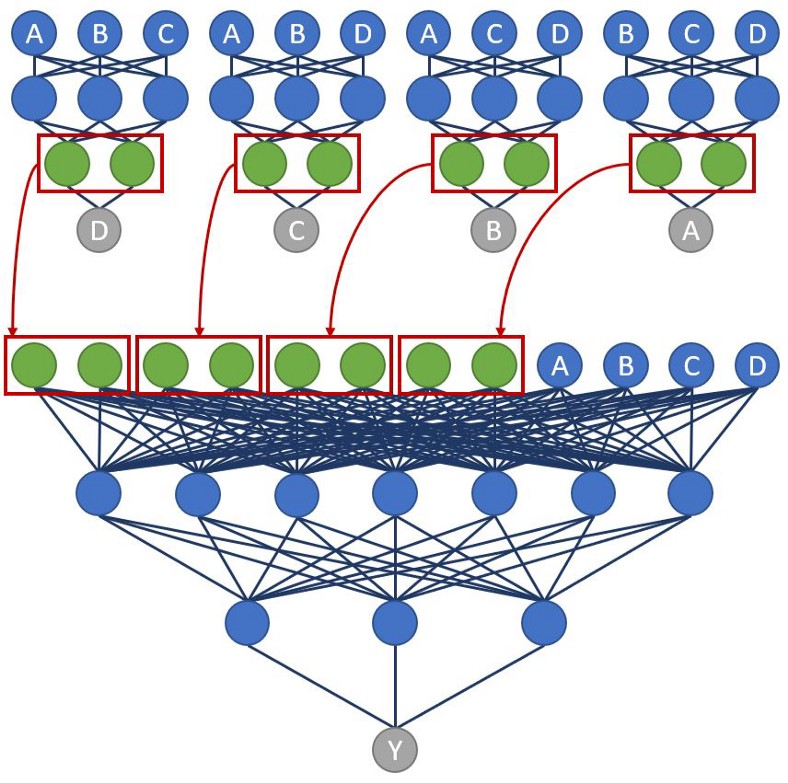

Each of these features will be a different auxiliary output of our overall model along with the target feature we are trying to predict (Severity_Severe). As we create our TensorFlow datasets, we will also have to define these as output features as well. Note that we rename each of these features by adding ‘_out’ to the end so that TensorFlow does not get confused by duplicate names. Notice that we also add an additional ‘_aux_out’ column for our target output. This is so that we can train a separate feature model around the target feature that will also feed into the final model as well. This is a process known as a skip connection which allows the model to learn deep and shallow interactions around the same feature set.

In [6]:
Y_train_df = X_train[model_cols].copy()
Y_train_df.columns = Y_train_df.columns + "_out"
Y_train_df['Severity_Severe_out'] = y_train['Severity_Severe']
Y_train_df['Severity_Severe_aux_out'] = y_train['Severity_Severe']
trainset = tf.data.Dataset.from_tensor_slices((dict(X_train),dict(Y_train_df))).batch(256)

Y_val_df = X_val[model_cols].copy()
Y_val_df.columns = Y_val_df.columns + "_out"
Y_val_df['Severity_Severe_out'] = y_val['Severity_Severe']
Y_val_df['Severity_Severe_aux_out'] = y_val['Severity_Severe']
valset = tf.data.Dataset.from_tensor_slices((dict(X_val),dict(Y_val_df))).batch(256)

Y_test_df = X_test[model_cols].copy()
Y_test_df.columns = Y_test_df.columns + "_out"
Y_test_df['Severity_Severe_out'] = y_test['Severity_Severe']
Y_val_df['Severity_Severe_aux_out'] = y_val['Severity_Severe']
testset = tf.data.Dataset.from_tensor_slices((dict(X_test),dict(Y_test_df))).batch(256)

In [7]:
'''The hidden_layers variable will have a separate list for each layer with the first number being the number of neurons and the second being the dropout rate
This is to add feature models to our main model, this will also return last layer output which will be used to train our main model.'''
def add_model(
    feature_outputs=None,hidden_layers=[[512,0],[64,0]],
    batch_norm=False,model_name=None,activation='sigmoid'):
    
    if batch_norm == True:
        layer = layers.BatchNormalization()(feature_outputs)
    else:
        layer = feature_outputs
    
    for i in range(len(hidden_layers)):
        layer = layers.Dense(hidden_layers[i][0], activation='relu',
                             name=model_name+'_L'+str(i))(layer)
        last_layer = layer
        
        if batch_norm == True:
            layer = layers.BatchNormalization()(layer)
        if hidden_layers[i][1] > 0:
            layer = layers.Dropout(hidden_layers[i][1])(layer)
        
    output_layer = layers.Dense(1, activation=activation,
                                name=model_name+'_out')(layer)
        
    return last_layer, output_layer

In [8]:
'''We should use embeddings for sparse categorical variables.

What is embedding for sparse categorical variables?
taking one hot encoded value of the category and representing it on a lower dimension like 3 or 4. 
As these embeddings are trained with the model the lower dimension mapping is much more accurate than any of the encoding techniques.

We take help of tensorflow.feature_column
feature_column.categorical_column_with_vocabulary_list - Column Name, Unique Categories of the Column
feature_column.embedding_column - Output from above function, dimensions of embedding (Generally 4th root of total features)

How to design the embedding layer?
output from feature_column.embedding_column is appended to a list.
This is a list of all the outputs for respective categorical variables.
Layer -> layers.DenseFeatures(List of embedding_column outputs)

Connecting Inputs to layer.
After defining the layer, we can define output as emb_outputs = emb_layer(emb_inputs)
emb_input example for sparse categorical variable 'Vehicle'
{'Vehicle':tf.keras.Input(shape=(1,),name='Vehicle',dtype='string')}
emb_inputs should be a dictionary containing key value pairs for all such variables.'''

emb_layers = {'Country':list(X_train['Country'].unique())}

def add_emb(emb_layers={},model_inputs={}):
    emb_inputs = {}
    emb_features = []
    
    for key,value in emb_layers.items():
        emb_inputs[key] = model_inputs[key]
        catg_col = feature_column.categorical_column_with_vocabulary_list(key, value)
        emb_col = feature_column.embedding_column(catg_col,dimension=int(len(value)**0.25))
        emb_features.append(emb_col)
    
    emb_layer = layers.DenseFeatures(emb_features)
    emb_outputs = emb_layer(emb_inputs)
    
    return emb_outputs

In [9]:
''' We need to define the feature engineering layers what to exclude from there.
We are creating a feature model for each of the features in model_cols.
"Country" is excluded as it is an embedding variable and "Severity_Severe" is excluded as it is the target column.

For feature engineering models of these features we also need to define that what will be the fetures used to engineer these features.
From the diagram above we can see that from a feature set of A,B,C,D,E - A,B,C,D will be used to determine E.
But there are some exceptions to it
1. Embedding variable (Country), the calculated embeddings will be concatenated with each and every feture model input separately.
2. It should not use itself.
3. It should not use the target column which is anyways not part of the training set.
4. It should not use closely related columns, for example - 'Gender_Male','Gender_Transgender' columns can easily determine 'Gender_Female'.

We are making a dict feature_layers which has all the feature it has to engineer for as keys and all the fetures it has to leave out while engineering that feature as value.
'''

feature_layers = {col:[col,'Country'] for col in model_cols}
feature_layers['Gender_Female'] += ['Gender_Male','Gender_Transgender']
feature_layers['Gender_Male'] += ['Gender_Female','Gender_Transgender']
feature_layers['Gender_Transgender'] += ['Gender_Female','Gender_Male']
feature_layers['Age_0-9'] += ['Age_10-19','Age_20-24','Age_25-59','Age_60_']
feature_layers['Age_10-19'] += ['Age_0-9','Age_20-24','Age_25-59','Age_60_']
feature_layers['Age_20-24'] += ['Age_0-9','Age_10-19','Age_25-59','Age_60_']
feature_layers['Age_25-59'] += ['Age_0-9','Age_10-19','Age_20-24','Age_60_']
feature_layers['Age_60_'] += ['Age_0-9','Age_10-19','Age_20-24','Age_25-59']
feature_layers['Contact_Dont-Know'] += ['Contact_No','Contact_Yes']
feature_layers['Contact_No'] += ['Contact_Dont-Know','Contact_Yes']
feature_layers['Contact_Yes'] += ['Contact_Dont-Know','Contact_No']

In [10]:
''' Also, its benificial to make a feture model for target variable as discussed above.
'''
feature_layers['Severity_Severe_aux'] = ['Country']

In [11]:
''' We will make a function to create a feature models for all the features
Input - Output feature: it is used to detect aux_out for target so it can be added along with engineered features. 
                        i.e. we are taking last layer for each and every feature, but we will also take output for this feature model as a feature.
                        To summarise, during training we are training the target auxilary feature model to predict target in feature model itslef, 
                        so it can be used in the main model for more accuracy.
        all_features: Final list of all the training columns.
        feature_layers: dictionary of all the features for which model is to be generated and the columns which needs to be excluded from their feature engineering.
        emb_layers: dictionary with keys as embedding feature and values as list of unique values for the embedding.
        hidden_layers: Model architecture for feature models
        batch_norm: Batch Normalization used in feature models if this is True

Output - model_inputs/output_layers: While making a keras model we specify that what are the inputs/ outputs for the model.
                                     These are lists to keep track of same.
         eng_layers: Last layer outputs of feature models which is to be used in main model.

Define input type for all the training columns.
Add embeddings, get embedding outputs.
Repeat this process for all the features for which feature model is to be generated
  Prepare feature column inputs for the feature models.
  Pass this feature column input to DenseFeature layer.
  Passing the inputs and input types in above prepared layer. This will just consolidate a input for particular feature model
  embedding output (Country) is added as an input to each and every feature model
  These are passed to add model to create a feature model.
  last layer of this model is appended to eng_layers which will be input to main model
  output of feature model is appended to output layer so it can be used to train feature model.
  Further output of target variable auxilary should also be added to eng_layers so that it can be used
'''

def feature_models(output_feature=None,all_features=[],feature_layers={},emb_layers={},hidden_layers=[],batch_norm=False):
    model_inputs = {}
    for feature in all_features:
        if feature in [k for k,v in emb_layers.items()]:
            model_inputs[feature] = tf.keras.Input(shape=(1,),name=feature,dtype='string')
        else:
            model_inputs[feature] = tf.keras.Input(shape=(1,),name=feature)      
    if len(emb_layers) > 0:
        emb_outputs = add_emb(emb_layers,model_inputs) 
    output_layers = []
    eng_layers = []
    for key,value in feature_layers.items():
        feature_columns = [feature_column.numeric_column(f)
                           for f in all_features if f not in value]
        feature_layer = layers.DenseFeatures(feature_columns)
        feature_outputs = feature_layer({k:v for k,v in model_inputs.items() if k not in value})
        
        if len(emb_layers) > 0:
            feature_outputs = layers.concatenate([feature_outputs,emb_outputs])
    
        last_layer, output_layer = add_model(feature_outputs=feature_outputs,hidden_layers=hidden_layers,batch_norm=batch_norm,
                                             model_name=key)
        output_layers.append(output_layer)
        eng_layers.append(last_layer)
        
        if key == output_feature + '_aux':
            eng_layers.append(feature_outputs)
    
    return model_inputs, output_layers, eng_layers

In [12]:
params = {'all_features': list(X_train.columns),
          'output_feature':y_train.columns[0],
          'emb_layers':emb_layers,
          'feature_layers':feature_layers,
          'hidden_layers':[[256,0],[128,0.1],[64,0.2]],
          'batch_norm': True,
          'learning_rate':0.001,
          'patience':3,
          'epochs':1
        }

In [13]:
''' we can chose test as True if we are choosing hyperopt for hyperparameter tuning
We will generate all the feature models.
All the last layers from these feature models will be concatenated to use as input for main model.
We will use add model function to create a main model
target columns is added to the list of auxilary outputs which we are getting from feature model.
A final model is created using all the inputs and outputs.
0.5/auxilary_feature_length weight is given to auxilary outputs...while 0.5 weight is given to our main target variable for loss function... This parameter is passed as loss_weights

'''
def final_model(params,test=True):
    print(params['batch_norm'],params['hidden_layers'])
    model_inputs, output_layers, eng_layers = feature_models(
        all_features=params['all_features'],
        feature_layers=params['feature_layers'],
        emb_layers=params['emb_layers'],
        hidden_layers=params['hidden_layers'],
        batch_norm=params['batch_norm'],
        output_feature=params['output_feature'])
    
    concat_layer = layers.concatenate(eng_layers)
    last_layer, output_layer = add_model(
        feature_outputs=concat_layer,
        hidden_layers=params['hidden_layers'],
        batch_norm=params['batch_norm'],
        model_name=params['output_feature']) 
    output_layers.append(output_layer)
    
    model = tf.keras.Model(
        inputs=[model_inputs],
        outputs=output_layers)
        
    aux_loss_wgt = 0.5 / len(params['feature_layers'])
    loss_wgts = [aux_loss_wgt for i in 
                 range(len(params['feature_layers']))]
    loss_wgts.append(0.5)
    
    model.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(
                      lr=params["learning_rate"]),
                  loss_weights=loss_wgts,
                  metrics=['accuracy'])
    
    es = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',mode='min',verbose=1,
        patience=params['patience'],restore_best_weights=True)
                 
    history = model.fit(
        trainset,validation_data=valset,
        epochs=params['epochs'], verbose=1, callbacks=[es])
    
    yhat = model.predict(testset)
    loss = tf.losses.binary_crossentropy(
        np.array(y_test[params['output_feature']]),
        yhat[-1])
    
    print('Binary Crossentropy:',loss)
    
    if test==True:
        sys.stdout.flush()
        return {'loss': loss, 'status': STATUS_OK}
    else:
        return history, model

# Training and Final Model Architecture

In [14]:
history, model = final_model(params,test=False)

True [[256, 0], [128, 0.1], [64, 0.2]]
990/990 [==============================] - 197s 150ms/step - loss: 0.2779 - Fever_out_loss: 0.4775 - Tiredness_out_loss: 0.4609 - Dry-Cough_out_loss: 0.4780 - Difficulty-in-Breathing_out_loss: 0.4641 - Sore-Throat_out_loss: 0.4733 - None_Sympton_out_loss: 0.2660 - Pains_out_loss: 0.4900 - Nasal-Congestion_out_loss: 0.5014 - Runny-Nose_out_loss: 0.4850 - Diarrhea_out_loss: 0.4998 - None_Experiencing_out_loss: 0.2340 - Age_0-9_out_loss: 0.5965 - Age_10-19_out_loss: 0.5946 - Age_20-24_out_loss: 0.5944 - Age_25-59_out_loss: 0.5959 - Age_60__out_loss: 0.5973 - Gender_Female_out_loss: 0.6922 - Gender_Male_out_loss: 0.6989 - Gender_Transgender_out_loss: 0.6990 - Severity_Mild_out_loss: 0.4684 - Severity_Moderate_out_loss: 0.4677 - Severity_None_out_loss: 0.4740 - Contact_Dont-Know_out_loss: 0.6963 - Contact_No_out_loss: 0.6962 - Contact_Yes_out_loss: 0.7037 - Severity_Severe_aux_out_loss: 0.1042 - Severity_Severe_out_loss: 0.0361 - Fever_out_accuracy: 0.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:2295: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:2295: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)


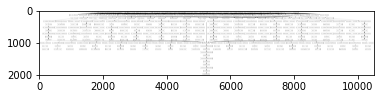

In [15]:
from tensorflow.keras.utils import plot_model

# Plot model
plot_model(model, to_file='model.png')

# Display the image
data = plt.imread('model.png')
plt.imshow(data);